In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import shutil
import os
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler

/home/guilherme-coelho/Documentos/tcc/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df_test = pd.read_csv('data/raw/fraudTest.csv')
df_test.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0



Valores ausentes no conjunto de treino:
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

Estatísticas descritivas para colunas numéricas no conjunto de treino:
          Unnamed: 0        cc_num            amt            zip  \
count  555719.000000  5.557190e+05  555719.000000  555719.000000   
mean   277859.000000  4.178387e+17      69.392810   48842.628015   
std    160422.401459  1.309837e+18     156.745941

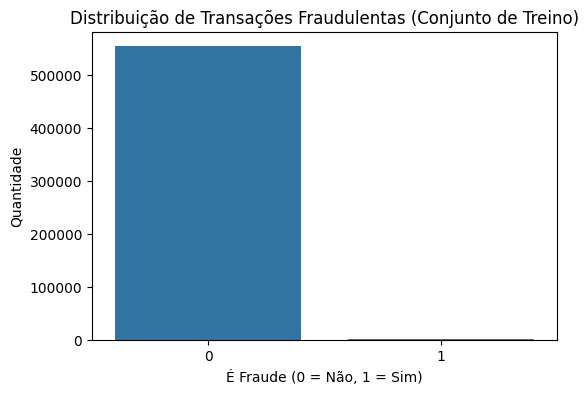

In [8]:
# Verificar valores ausentes no conjunto de treino
print("\nValores ausentes no conjunto de treino:")
print(df_test.isnull().sum())

# Estatísticas descritivas para colunas numéricas
print("\nEstatísticas descritivas para colunas numéricas no conjunto de treino:")
print(df_test.describe())

# Distribuição da variável alvo ('is_fraud') no conjunto de treino
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=df_test)
plt.title('Distribuição de Transações Fraudulentas (Conjunto de Treino)')
plt.xlabel('É Fraude (0 = Não, 1 = Sim)')
plt.ylabel('Quantidade')
plt.show()

In [16]:
# List of columns to drop
columns_to_drop = ['Unnamed: 0', 'cc_num', 'trans_date_trans_time', 'first', 'last', 'dob', 'street', 'trans_num', 'unix_time']

# Drop the columns from the DataFrame
df_test = df_test.drop(columns=columns_to_drop)

print(df_test.head())  # Display the first few rows of the updated DataFrame

                               merchant        category    amt gender  \
0                 fraud_Kirlin and Sons   personal_care   2.86      M   
1                  fraud_Sporer-Keebler   personal_care  29.84      F   
2  fraud_Swaniawski, Nitzsche and Welch  health_fitness  41.28      F   
3                     fraud_Haley Group        misc_pos  60.05      M   
4                 fraud_Johnston-Casper          travel   3.19      M   

         city state    zip      lat      long  city_pop  \
0    Columbia    SC  29209  33.9659  -80.9355    333497   
1     Altonah    UT  84002  40.3207 -110.4360       302   
2    Bellmore    NY  11710  40.6729  -73.5365     34496   
3  Titusville    FL  32780  28.5697  -80.8191     54767   
4    Falmouth    MI  49632  44.2529  -85.0170      1126   

                      job  merch_lat  merch_long  is_fraud  
0     Mechanical engineer  33.986391  -81.200714         0  
1  Sales professional, IT  39.450498 -109.960431         0  
2       Librarian, publ

In [18]:
print(f"👉 Data Types: {df_test.dtypes}\n")
df_test.head()

👉 Data Types: merchant       object
category       object
amt           float64
gender         object
city           object
state          object
zip             int64
lat           float64
long          float64
city_pop        int64
job            object
merch_lat     float64
merch_long    float64
is_fraud        int64
dtype: object



,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,job,merch_lat,merch_long,is_fraud
0,fraud_Kirlin and Sons,personal_care,2.86,M,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,33.986391,-81.200714,0
1,fraud_Sporer-Keebler,personal_care,29.84,F,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",39.450498,-109.960431,0
2,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,F,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",40.495810,-74.196111,0
3,fraud_Haley Group,misc_pos,60.05,M,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,28.812398,-80.883061,0
4,fraud_Johnston-Casper,travel,3.19,M,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,44.959148,-85.884734,0


In [19]:
df_test.select_dtypes(include=['object'])

encoder = LabelEncoder()
df_test["merchant"] = encoder.fit_transform(df_test["merchant"])
df_test["category"] = encoder.fit_transform(df_test["category"])
df_test["gender"] = encoder.fit_transform(df_test["gender"])
df_test["job"] = encoder.fit_transform(df_test["job"])
df_test["city"] = encoder.fit_transform(df_test["city"])
df_test["state"] = encoder.fit_transform(df_test["state"])

df_test.head()

,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,job,merch_lat,merch_long,is_fraud
0,319,10,2.86,1,157,39,29209,33.9659,-80.9355,333497,275,33.986391,-81.200714,0
1,591,10,29.84,0,16,43,84002,40.3207,-110.4360,302,392,39.450498,-109.960431,0
2,611,5,41.28,0,61,33,11710,40.6729,-73.5365,34496,259,40.495810,-74.196111,0
3,222,9,60.05,1,764,8,32780,28.5697,-80.8191,54767,407,28.812398,-80.883061,0
4,292,13,3.19,1,247,21,49632,44.2529,-85.0170,1126,196,44.959148,-85.884734,0


In [20]:
# Define the output file path
output_file_path = os.path.join(os.getcwd(), 'data', 'processed', 'fraudTest_normalized.csv')

# Ensure the destination folder exists
os.makedirs(os.path.dirname(output_file_path), exist_ok=True)

# Write the filtered and balanced dataset to a CSV file
df_test.to_csv(output_file_path, index=False)

print(f"Test dataset written in {output_file_path}")

Test dataset written in /home/guilherme-coelho/Documentos/tcc/notebooks/data/processed/fraudTest_normalized.csv
